In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [15]:
# Download daily AAPL data from 2021 onwards
stock_data = yf.download("AAPL", start="2021-01-01", end=None)

# Reset index so Date becomes a column
stock_data = stock_data.reset_index()

# Rename to match your earlier style
stock_data.rename(columns={"Date": "date", "Close": "close"}, inplace=True)

print("Data shape:", stock_data.shape)
stock_data.head()

/tmp/ipython-input-124975503.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download("AAPL", start="2021-01-01", end=None)
[*********************100%***********************]  1 of 1 completed

Data shape: (1233, 6)


Price,date,close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2021-01-04,125.974449,130.062945,123.394799,129.975338,143301900
1,2021-01-05,127.531944,128.242575,125.020436,125.468231,97664900
2,2021-01-06,123.239052,127.570919,123.024891,124.329321,155088000
3,2021-01-07,127.444382,128.135539,124.465620,124.952346,109578200
4,2021-01-08,128.544403,129.109007,126.772712,128.914305,105158200


In [16]:
close_prices = stock_data['close']
values = close_prices.values  # numpy array

# 80% training, 20% testing
training_data_len = math.ceil(len(values) * 0.8)

print("Total samples:", len(values))
print("Training samples:", training_data_len)
print("Testing samples:", len(values) - training_data_len)

Total samples: 1233
Training samples: 987
Testing samples: 246


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_values = values[:training_data_len]
test_values  = values[training_data_len:]  # for y_test later

# Fit scaler on training data only
scaled_train = scaler.fit_transform(train_values.reshape(-1, 1))

# Transform the full series using the same scaler
scaled_full = scaler.transform(values.reshape(-1, 1))

print("First 5 scaled values:", scaled_full[:5].ravel())

First 5 scaled values: [0.09756152 0.1096844  0.07627036 0.10900285 0.11756494]


In [18]:
sequence_length = 60  # last 60 days

class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]      # shape: (seq_length, 1)
        y = self.data[idx + self.seq_length]           # shape: (1,)
        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

# Train dataset uses the first 'training_data_len' points
train_data = scaled_full[:training_data_len]
test_data  = scaled_full[training_data_len - sequence_length:]  # overlap for context

train_dataset = StockDataset(train_data, sequence_length)
test_dataset  = StockDataset(test_data, sequence_length)

print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))  # should match len(test_values)

Train dataset length: 927
Test dataset length: 246


In [19]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For testing, we can use full batch at once or batch_size=32; shuffle=False is important
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)

(29, 8)

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))   # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]               # take last time step: (batch, hidden_size)
        out = self.fc1(out)
        out = self.fc2(out)               # (batch, output_size)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTMModel().to(device)
print(model)

Using device: cuda
LSTMModel(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=100, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)


In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 60

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        # x_batch: (batch, seq_len, 1), y_batch: (batch, 1)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Ensure correct shape for LSTM (batch, seq_len, features)
        # Already (batch, seq_len, 1) from our Dataset

        optimizer.zero_grad()

        outputs = model(x_batch)         # (batch, 1)
        # y_batch currently shape (batch, 1) or (batch,)
        y_batch = y_batch.view(-1, 1)    # make sure it matches

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)

    epoch_loss /= len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

Epoch [1/60], Loss: 0.020952
Epoch [2/60], Loss: 0.111452
Epoch [3/60], Loss: 0.044771
Epoch [4/60], Loss: 0.050373
Epoch [5/60], Loss: 0.031219
Epoch [6/60], Loss: 0.062493
Epoch [7/60], Loss: 0.037499
Epoch [8/60], Loss: 0.026837
Epoch [9/60], Loss: 0.008097
Epoch [10/60], Loss: 0.005614
Epoch [11/60], Loss: 0.007196
Epoch [12/60], Loss: 0.002730
Epoch [13/60], Loss: 0.003936
Epoch [14/60], Loss: 0.002144
Epoch [15/60], Loss: 0.003152
Epoch [16/60], Loss: 0.001776
Epoch [17/60], Loss: 0.002416
Epoch [18/60], Loss: 0.001584
Epoch [19/60], Loss: 0.001942
Epoch [20/60], Loss: 0.001492
Epoch [21/60], Loss: 0.001651
Epoch [22/60], Loss: 0.001461
Epoch [23/60], Loss: 0.001506
Epoch [24/60], Loss: 0.001444
Epoch [25/60], Loss: 0.001436
Epoch [26/60], Loss: 0.001414
Epoch [27/60], Loss: 0.001396
Epoch [28/60], Loss: 0.001378
Epoch [29/60], Loss: 0.001360
Epoch [30/60], Loss: 0.001342
Epoch [31/60], Loss: 0.001324
Epoch [32/60], Loss: 0.001307
Epoch [33/60], Loss: 0.001289
Epoch [34/60], Loss

In [23]:
model.eval()
all_predictions = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_predictions.append(outputs.cpu().numpy())

# Concatenate all batches
all_predictions = np.vstack(all_predictions)  # shape: (len(test_dataset), 1)

# Inverse transform to original price scale
predictions = scaler.inverse_transform(all_predictions)

print("Predictions shape:", predictions.shape)
print("First 5 predictions:", predictions[:5].ravel())

Predictions shape: (246, 1)
First 5 predictions: [241.91597 243.41368 244.31215 245.61415 247.04326]


In [24]:
# y_test = actual close prices (original scale) for the test region
y_test = test_values  # from earlier, shape: (num_test_samples,)

# Flatten predictions
pred_flat = predictions.ravel()

print("len(y_test):", len(y_test))
print("len(pred_flat):", len(pred_flat))

rmse = np.sqrt(mean_squared_error(y_test, pred_flat))
mae  = mean_absolute_error(y_test, pred_flat)
r2   = r2_score(y_test, pred_flat)

len(y_test): 246
len(pred_flat): 246


In [25]:
print("LSTM PERFORMANCE ON AAPL")
print("RMSE :", rmse)
print("MAE  :", mae)
print("R²   :", r2)

LSTM PERFORMANCE ON AAPL
RMSE : 6.993992890280115
MAE  : 5.036683369458206
R²   : 0.911982777726833


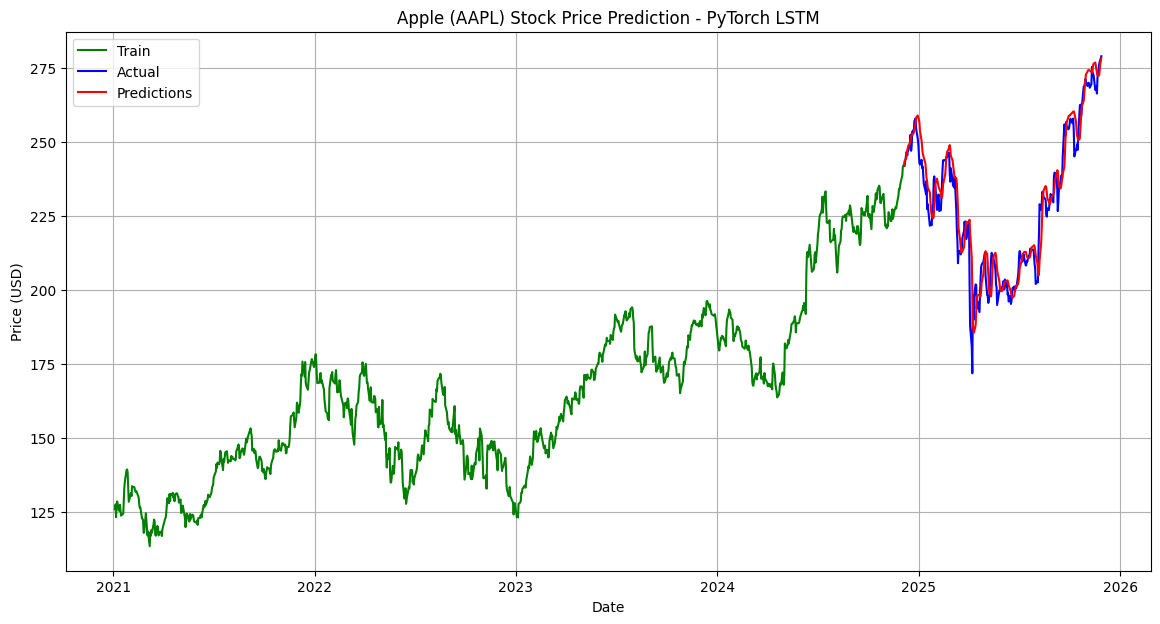

In [26]:
# Ensure date is datetime and set as index
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date', inplace=True)

data = stock_data[['close']]

train = data.iloc[:training_data_len]
validation = data.iloc[training_data_len:].copy()

# Add predictions to validation dataframe
validation['Predictions'] = pred_flat

plt.figure(figsize=(14, 7))
plt.title('Apple (AAPL) Stock Price Prediction - PyTorch LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

plt.plot(train['close'], label='Train', color='green')
plt.plot(validation['close'], label='Actual', color='blue')
plt.plot(validation['Predictions'], label='Predictions', color='red')

plt.legend()
plt.grid(True)
plt.show()